In [1]:
# Along-fjord Layer Properties
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
# Find the layer interface
def Layer_S(Szx):
    #Szx = State.S.data.mean(axis=(0,2))
    Sma = np.ma.masked_where(Szx==0, Szx)
    X = Szx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0]] = 0 # Remove data at fjord head
    for i in range(1,len(X)):
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        itf[i] = np.argmin(meanS)
    return itf

In [3]:
# Find the interface
def Layer_U(Uzx):
    # Layer interface, zero velocity crossing point
    X = Uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0]] = 0 # Remove data at fjord head and end
    for i in range(1,X):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [4]:
def DynamicalP(Qsg, hs):
      
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')


    T0 = 275 # or 81/275 for one/two week run
    Tn = len(File2.T)
    Grid = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    State = File2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))

    x = Grid.X.data
    z = Grid.Z.data
    drF = Grid.drF.data # r cell face separation
    HFacC = Grid.HFacC.data.mean(1) # vertical fraction of open cell at cell center
    U = State.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    s = State.S.data.mean(axis=(0,2)) # Salinity
    pt = State.Temp.data.mean(axis=(0,2)) # Potential temperature
    pres = gsw.p_from_z(z, 56)
    p = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(s, pt, p) # Density
    g = 9.81
    
    Sma = np.ma.masked_where(s==0, s)
    s1 = np.empty(len(x))
    s2 = np.empty(len(x))
    u1 = np.empty(len(x))
    u2 = np.empty(len(x))
    F1 = np.empty(len(x))
    F2 = np.empty(len(x))
    for i in range(1,len(x)):
        gh = drF * HFacC[:,i] # grid height
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        l = np.argmin(meanS) # index of the layer interface
        #l = np.where(u[:, i] < 0)[-1][0]
        h1 = gh[:l].sum()    
        h2 = gh[l:].sum()
        s1[i] = np.sum(s[:l,i] * gh[:l]) / h1
        s2[i] = np.sum(s[l+1:,i] * gh[l+1:]) / h2
        u1[i] = np.sum(u[:l,i] * gh[:l]) / h1
        u2[i] = np.sum(u[l+1:,i] * gh[l+1:]) / h2
        
        rho1 = np.sum(rho[:l,i] * gh[:l]) / h1
        rho2 = np.sum(rho[l+1:,i] * gh[l+1:]) / h2
        gr = g * (rho2-rho1) / rho2 # Reduced gravity
        F1[i] = u1[i] / np.sqrt(gr*h1)
        F2[i] = u2[i] / np.sqrt(gr*h2)
    
    return (s1, s2, u1, u2, F1, F2)

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


(array([ 0.        , 21.83838857, 21.87123943, 21.88752885, 21.89402551,
        21.89660792, 21.89743304, 21.89730209, 21.89686125, 21.89663362,
        21.89689104, 21.89762633, 21.89866649, 21.89978192, 21.90081294,
        21.90172874, 21.90255592, 21.90333808, 21.90413234, 21.90495545,
        21.90578998, 21.90662024, 21.90743785, 21.90824608, 21.90903714,
        21.90979678, 21.91049616, 21.9111237 , 21.91170566, 21.91225996,
        21.91283444, 21.91346917, 21.91420829, 21.9150637 , 21.91603181,
        21.91710712, 21.91828485, 21.91957001, 21.92095655, 21.92244949,
        21.9240716 , 21.92586192, 21.92785291, 21.93004565, 21.93245858,
        21.93508965, 21.93787952, 21.82004897, 21.71599126, 20.0107573 ,
        19.61219735, 19.50818801, 19.51449585, 19.51422477, 19.50774372,
        19.49450147, 19.47624636, 19.45266902, 19.42713714, 19.40084267,
        19.3707732 , 19.36196125, 19.26421329, 19.30568627, 19.22462622,
        19.28785308, 19.36002493, 19.44318692, 19.5

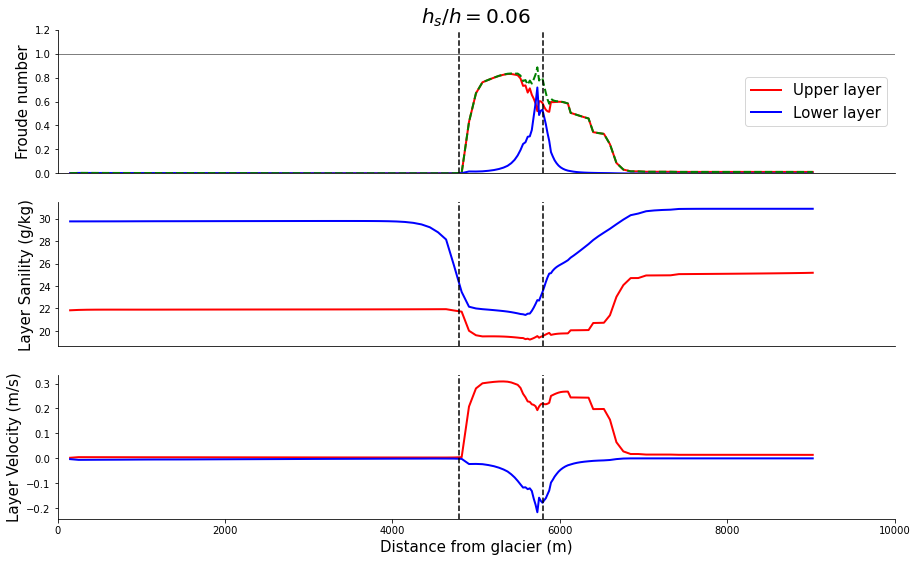

In [5]:
Qsg = 700
hs = 9
X = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc').X.data[:120]
Xp = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc').Xp1.data[:121]
s1, s2, u1, u2, F1, F2 = DynamicalP(Qsg,hs)
G = np.sqrt(F1**2 + F2**2) # Composite Froude number

# Make plots
fig1 = plt.figure(figsize=(15,9))
fig1.tight_layout()

ax1 = fig1.add_subplot(311)
ax1.plot(X[1:],F1[1:],'-r',linewidth=2,label='Upper layer')
ax1.plot(X[1:],-F2[1:],'-b',linewidth=2, label='Lower layer')
ax1.plot(X[1:],G[1:],'--g',linewidth=2)
ax1.legend(fontsize=15, loc="right")
ax1.axhline(y=1, color='k',lw=.5)
ax1.axvline(x=4800, color='k', linestyle='--')
ax1.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Froude number', size=15)
ax1.axes.get_xaxis().set_visible(False)
#ax1.spines['left'].set_linewidth(2)
#ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim([0, 10000])
ax1.set_ylim([0, 1.2])
ax1.set_title(r'$h_s/h=$'+str(hs/150), loc='center', size=20)

P = s2 / (s2-s1)
Pmean = P[1:].mean()
ax2 = fig1.add_subplot(312)
ax2.plot(X[1:],s1[1:],'-r',linewidth=2)
ax2.plot(X[1:],s2[1:],'-b',linewidth=2)
#ax2.plot(X[1:],P[1:],'-b',linewidth=2)
#ax2.axhline(y=Pmean, color='k',lw=.5)

ax2.axvline(x=4800, color='k', linestyle='--')
ax2.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Layer Sanility (g/kg)', size=15)
ax2.axes.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim([0, 10000])

ax3 = fig1.add_subplot(313)
ax3.plot(X[1:],u1[1:],'-r',linewidth=2)
ax3.plot(X[1:],u2[1:],'-b',linewidth=2)
ax3.axvline(x=4800, color='k', linestyle='--')
ax3.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Layer Velocity (m/s)', size=15)
#ax3.tick_params(axis='x', labelsize=15)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim([0, 10000])
ax3.set_xlabel(r'Distance from glacier (m)', size=15)
#X[48:72], Xp[48:73], Xp[72] - Xp[48]
#s1 ,s2

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1.savefig(fig_path + '/Dynamics_18m.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/Mom_mag.png', dpi=200, bbox_inches='tight')